# Identificador de especies arbóreas de Costa Rica.
## Utilizando redes convolucionales artificiales

Se utilizará la arquitectura ViT: Vision Transformer
usando como base un modelo preentrenado debido a los pocos datos para iniciar un modelo desde cero, y además se necesitan más recursos computacionales para entrenar un modelo necesario para iniciar

# Instalación de paquetes necesarios

In [29]:
!python --version

Python 3.10.12


In [30]:
import torch
torch.__version__

'2.2.1+cu121'

**torchinfo**: para presentar resumen del modelo

In [31]:
!pip install torchinfo

**torchvision**: para importar modelos pre-entrenados

In [32]:
!pip install torch torchvision

# Importación de bibliotecas necesarias

In [33]:
import shutil
import os

#code = "drive/MyDrive/Colab Notebooks/transformer"
code = "drive/MyDrive/Colab Notebooks/transformer/lib"
folder = os.getcwd()

for item in os.listdir(code):
  origen_item = os.path.join(code, item)
  destino_item = os.path.join(folder, item)
  if os.path.isdir(origen_item):
      shutil.copytree(origen_item, destino_item, dirs_exist_ok=True)
  else:
      shutil.copy2(origen_item, destino_item)

In [34]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Asignación de variables globales

La base de datos que se utilizará es de 1289 imágenes:

60% = 781 imágenes para el entrenamiento (train)

30% = 389 imágenes para la prueba (test)

10% = 119 imágenes para la validación (validation)

In [35]:
import os

train_dir = "drive/MyDrive/Colab Notebooks/dataset/train"
test_dir = "drive/MyDrive/Colab Notebooks/dataset/test"
validate_dir = "drive/MyDrive/Colab Notebooks/dataset/validate"

class_names = os.listdir(train_dir)
print("train classes")
print(class_names)

print("test classes")
print(os.listdir(test_dir))

print("validation classes")
print(os.listdir(validate_dir))

train classes
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']
test classes
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']
validation classes
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']


# Dimensiones, Patches y Batches

In [36]:
batch_size = 32
image_size = 224
patch_size = 16
rgb = 3
patches = patch_size * patch_size * rgb # 768
print(patches)

768


# Selección de Tarjeta Gráfica o CPU

In [37]:
import torch
import tensorflow as tf

use_cuda = torch.cuda.is_available()
if use_cuda:
  device = "cuda:0"
  print('CUDNN VERSION:', torch.backends.cudnn.version())
  print('Number CUDA Devices:', torch.cuda.device_count())
  print('CUDA Device Name:',torch.cuda.get_device_name(0))
  print('CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
  print('GPU name:', tf.test.gpu_device_name())
else:
  device = "cpu"
  print("No GPU available")

print("Device:", device)

No GPU available
Device: cpu


# Obtención de modelo pre-entrenado

El modelo pre-entrenado seleccionado es: **ViT_B_16_Weights**

In [38]:
def set_seeds(seed: int=42):
    """
    Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [39]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=patches, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

# Preparación del modelo pre-entrenado

Como se observa en el output, se confirma que las primeras capas no se entrenarán puesto que el el código anterior se congelaron las capas del modelo pre-entrenado

**Trainable = False**

sólo la capa final linear se entrenará

**Linear = True**

In [40]:
from torchinfo import summary

# Print a summary using torchinfo
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 19]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [41]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


# Trasladar las imágenes a DataLoader para que sea recibido por la red neuronal

In [42]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders

  # Train dataset
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )

  # Test dataset
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [43]:
# Create dataset
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=batch_size)

In [44]:
train_dataloader_pretrained.dataset

Dataset ImageFolder
    Number of datapoints: 781
    Root location: drive/MyDrive/Colab Notebooks/dataset/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [45]:
test_dataloader_pretrained.dataset

Dataset ImageFolder
    Number of datapoints: 389
    Root location: drive/MyDrive/Colab Notebooks/dataset/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

# Entrenar la red usando el dataloader

In [47]:
import engine

import time
start_time = time.time()

# Create optimizer and loss function
learnable_rate = 1e-3
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=learnable_rate,
                             weight_decay=0.3 # from the ViT 4.1
                             )
# loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
# model.train() ##
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=15,
                                      device=device)

elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9710 | train_acc: 0.5439 | test_loss: 1.1655 | test_acc: 0.8188
Epoch: 2 | train_loss: 0.8912 | train_acc: 0.8688 | test_loss: 0.7457 | test_acc: 0.9038
Epoch: 3 | train_loss: 0.6728 | train_acc: 0.9157 | test_loss: 0.7143 | test_acc: 0.9062
Epoch: 4 | train_loss: 0.6281 | train_acc: 0.9269 | test_loss: 0.6628 | test_acc: 0.9423
Epoch: 5 | train_loss: 0.6131 | train_acc: 0.9425 | test_loss: 0.6480 | test_acc: 0.9279
Epoch: 6 | train_loss: 0.6008 | train_acc: 0.9525 | test_loss: 0.6433 | test_acc: 0.9135
Epoch: 7 | train_loss: 0.6034 | train_acc: 0.9325 | test_loss: 0.6565 | test_acc: 0.9351
Epoch: 8 | train_loss: 0.5856 | train_acc: 0.9363 | test_loss: 0.6463 | test_acc: 0.9207
Epoch: 9 | train_loss: 0.5856 | train_acc: 0.9332 | test_loss: 0.6394 | test_acc: 0.9327
Epoch: 10 | train_loss: 0.5805 | train_acc: 0.9450 | test_loss: 0.6545 | test_acc: 0.9447
Epoch: 11 | train_loss: 0.5858 | train_acc: 0.9413 | test_loss: 0.6333 | test_acc: 0.9351
Epoch: 12 | train_l

In [48]:
# export the model
torch.save(pretrained_vit, "model-15ep.pth")

In [53]:
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [56]:
pretrained_vit.modules

<bound method Module.modules of VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_2): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_3): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_4): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_5): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False

In [57]:
pretrained_vit.heads

Linear(in_features=768, out_features=19, bias=True)

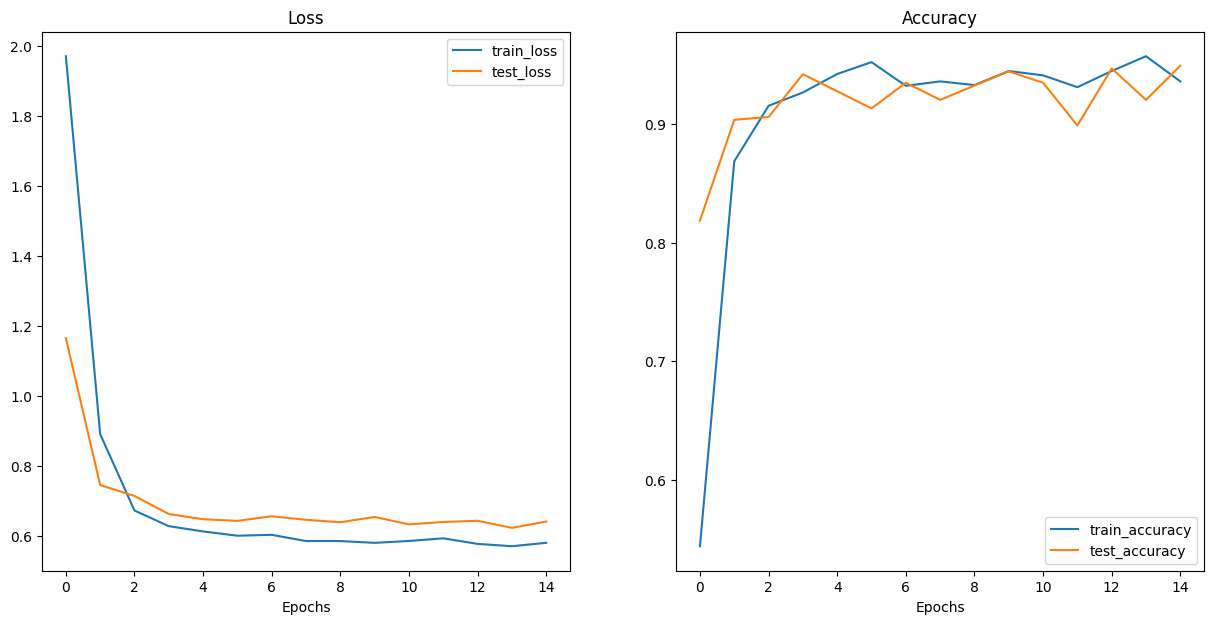

In [58]:
from helper_functions import plot_loss_curves

# Plot ViT model's loss curves
plot_loss_curves(pretrained_vit_results)

# Preparación de prueba del ViT

In [65]:
# Setup custom image path
class_test = "6"
file_test = "0639"
test_dir = validate_dir + "/" + class_test + "/" + file_test + ".JPG"

# Ejecutar predicción usando el modelo entrenado

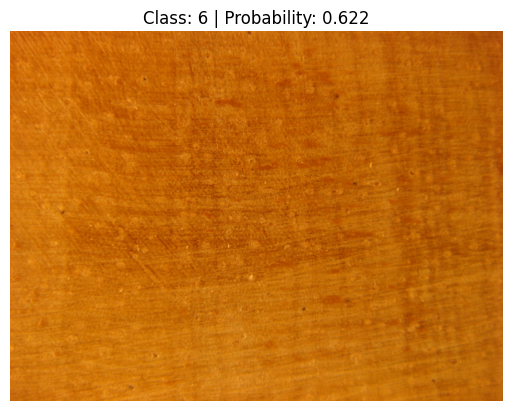

In [66]:
import requests

# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=test_dir,
                    class_names=class_names)

# Ejecutar predicción usando el modelo entrenado exportado

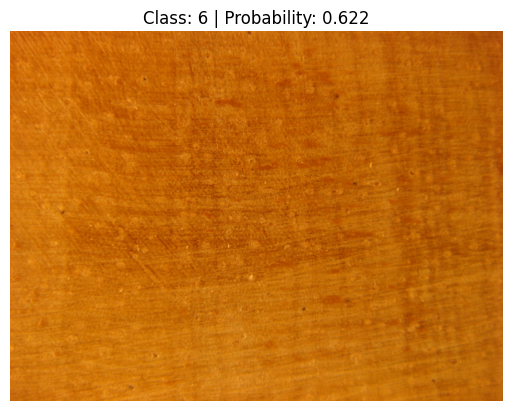

In [67]:
import torch
import requests

# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = test_dir
model = torch.load("model-15ep.pth")
model.eval()

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

# El resto de código es solo prueba ***

In [ ]:
!pip install tensorflowjs

In [ ]:
!pip install tensorrt

  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1.post1-py2.py3-none-any.whl size=17281 sha256=6e70fe0bafa32ac07bf0a0f5de45efaa70e489df5432880d5356f5d32789e85b
  Stored in directory: /root/.cache/pip/wheels/f4/c8/0e/b79b08e45752491b9acfdbd69e8a609e8b2ed7640dda5a3e59
Successfully built tensorrt


In [ ]:
import tensorrt as trt
trt.__version__

'8.6.1'

In [ ]:
!tensorflowjs_converter --help

2024-04-23 06:47:46.922162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: TensorFlow.js model converters. [-h]
                                       [--input_format {tf_saved_model,keras_saved_model,keras_keras,tfjs_layers_model,keras,tf_hub,tf_frozen_model}]
                                       [--output_format {keras_saved_model,tfjs_graph_model,keras_keras,tfjs_layers_model,keras}]
                                       [--signature_name SIGNATURE_NAME]
                                       [--saved_model_tags SAVED_MODEL_TAGS]
                                       [--quantize_float16 [QUANTIZE_FLOAT16]]
                                       [--quantize_uint8 [QUANTIZE_UINT8]]
                                       [--quantize_uint16 [QUANTIZE_UINT16]]
                                       [--quantization_bytes {1,2}] [--split_weights_by_layer]
                                       [--version] [--skip_op_check]
       

In [ ]:
#!tensorflowjs_converter --input_format tf_frozen_model --output_node_names activations model.pth javascript
!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='output_node' model.pth javascript

# tf_saved_model,keras_saved_model,keras_keras,tfjs_layers_model,keras,tf_hub,tf_frozen_model

2024-04-23 20:34:19.335444: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 20:34:21.384170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 963, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 949, in convert
    _dispatch_converter(input_format, output_fo

In [ ]:
!ls

drive	   going_modular	javascript  __pycache__  ViT.py
format.py  helper_functions.py	model.pth   sample_data


In [ ]:
torch.onnx.export(model, model, "onnx.onnx", verbose=True)


RuntimeError: Only tuples, lists and Variables are supported as JIT inputs/outputs. Dictionaries and strings are also accepted, but their usage is not recommended. Here, received an input of unsupported type: VisionTransformer